In [64]:
# from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
import numpy as np
import cmath
import sounddevice as sd
from scipy.signal import butter, sosfilt
from scipy.io.wavfile import write


# Method for sampling

In [65]:
# # Load your audio file (WAV, MP3, etc.)
# audio = AudioSegment.from_file("data/rpp16.wav")
# 
# # Define start and end times in milliseconds (e.g. from minute 1:00 to 2:30)
# start_time = 1 * 60 * 1000 + 10 * 1000  # 1 minute and 10 seconds in milliseconds
# end_time = 3 * 60 * 1000 + 57 * 1000  # 3 minutes and 57 seconds in milliseconds
# 
# # Cut the segment
# cut_audio = audio[start_time:end_time]
# 
# # Export the result
# cut_audio.export("sample2.wav", format="wav")


# Methods for plotting raw (time domain) signal, Frequency domain signal, amplitude and phase of signal

In [66]:
def plot_signal(data, title):
    plt.figure(figsize=(15, 7))
    time = np.arange(len(data)) / samplerate
    plt.plot(time, data)
    plt.title(title, fontsize=16)
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [67]:
def plot_dft(data, title):
    N = len(data)
    dft = fft(data)
    freq = fftfreq(N, 1 / samplerate)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Real part
    ax1.plot(freq, dft.real)
    ax1.set_title(f'{title} – Real Part', fontsize=16)
    ax1.set_xlabel('Frequency (Hz)', fontsize=12)
    ax1.set_ylabel('Amplitude', fontsize=12)
    ax1.grid(True)

    # Imaginary part
    ax2.plot(freq, dft.imag)
    ax2.set_title(f'{title} – Imaginary Part', fontsize=16)
    ax2.set_xlabel('Frequency (Hz)', fontsize=12)
    ax2.set_ylabel('Amplitude', fontsize=12)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [68]:
def plot_amplitude(data, title="Signal DFT"):
    N = len(data)
    dft = fft(data)
    amplitude = np.abs(dft)
    freq = fftfreq(N, 1 / samplerate)

    plt.figure(figsize=(15, 7))
    plt.plot(freq, amplitude)
    plt.title(title, fontsize=16)
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# phase = np.zeros(N)
# for i in range(N):
#     if np.abs(dft[i]) > 1e-8:  # avoid undefined phase for near-zero amplitude
#         phase[i] = cmath.phase(dft[i])
# 
# plt.figure(figsize=(10, 4))
# plt.plot(n, phase)
# plt.xlabel('n (Frequency bin)')
# plt.ylabel('Phase of DFT of x[n]')
# plt.title(f'{title} – Phase spectre')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


## 1. First show the signals

Samplerate: 44100


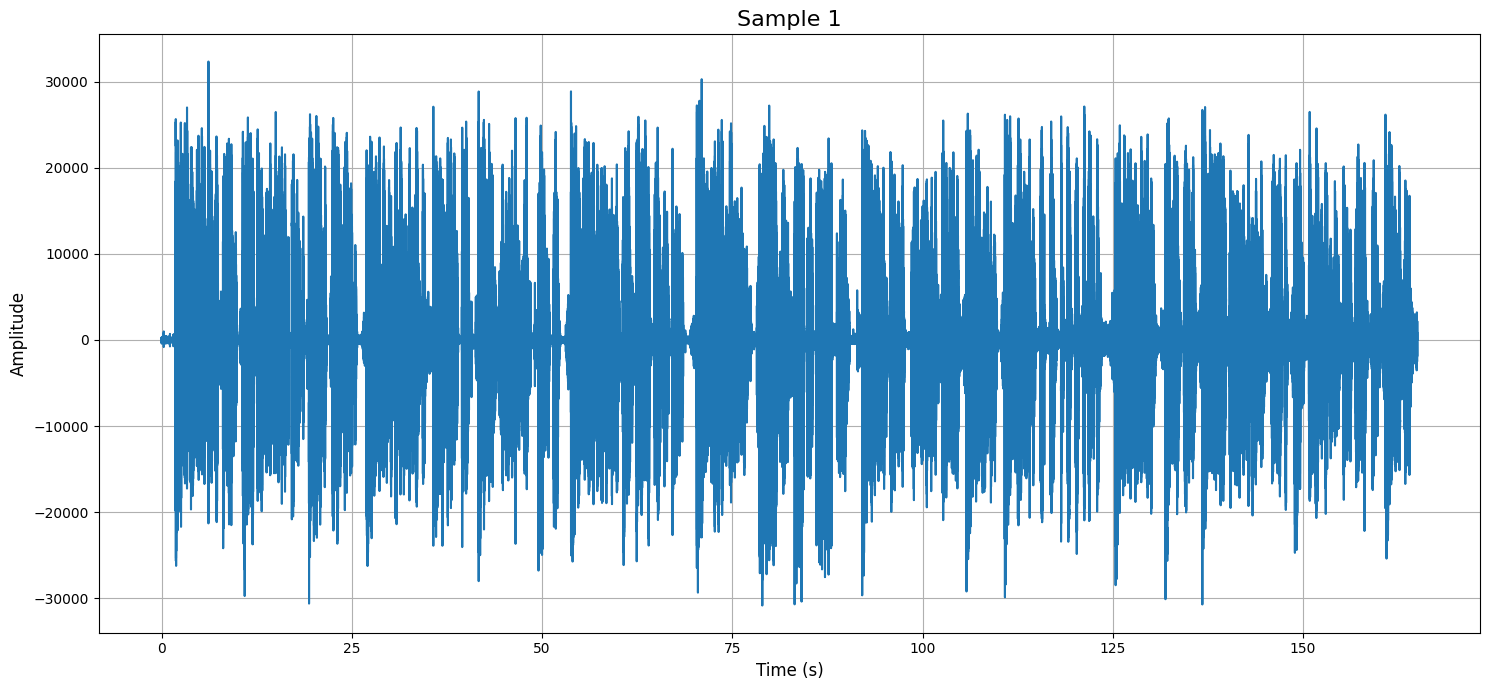

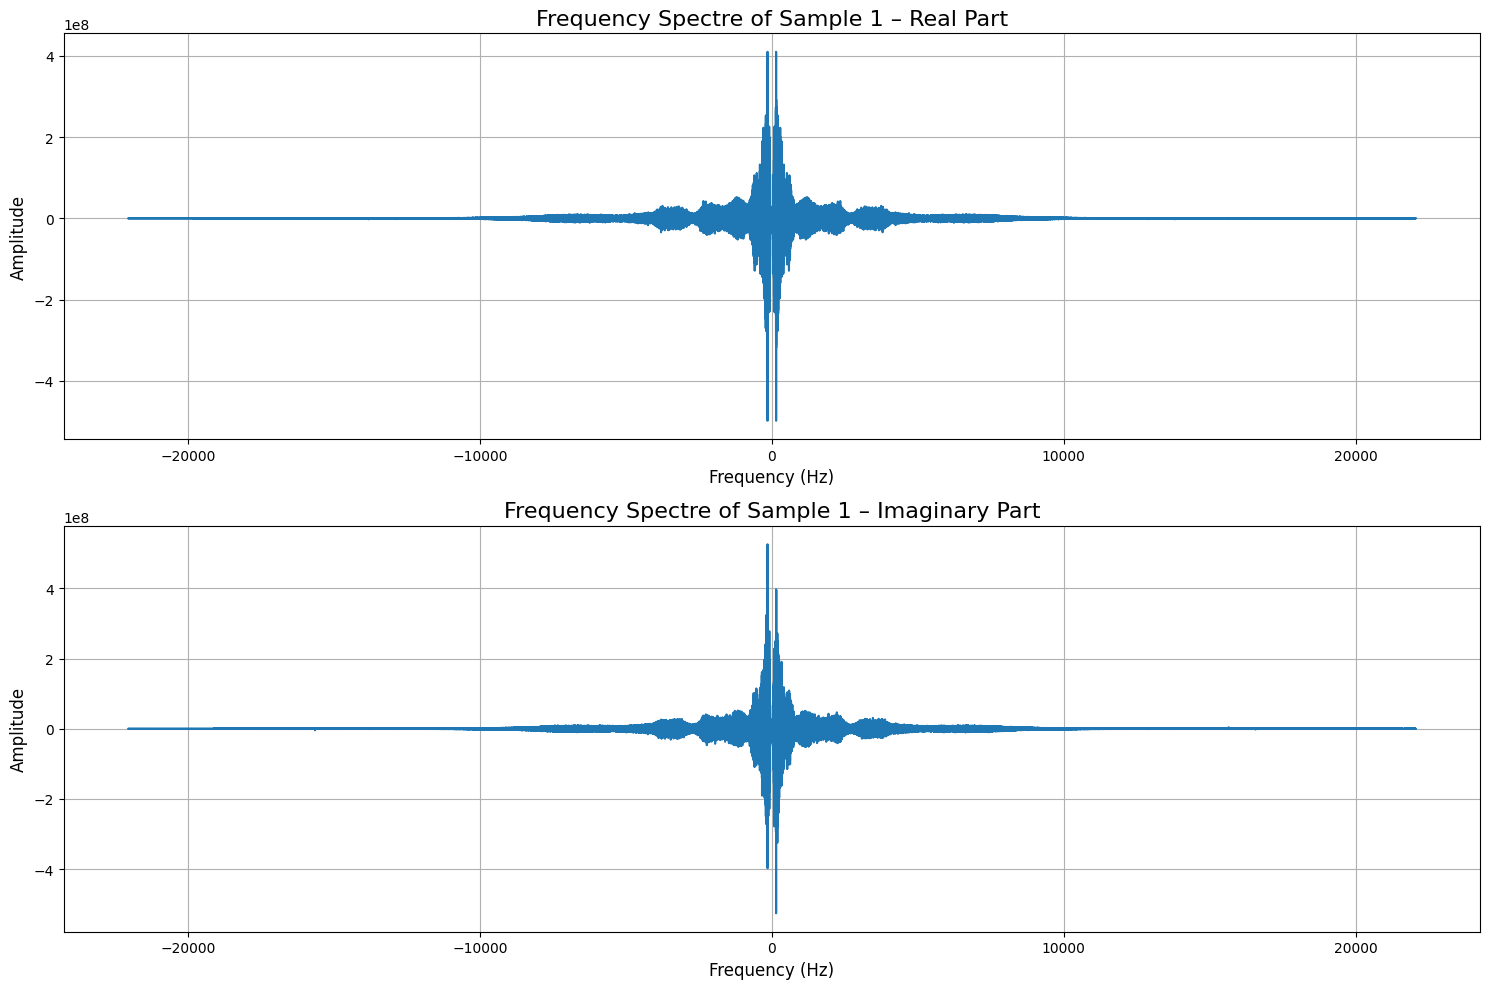

In [69]:
samplerate, signal1 = wavfile.read("sample1.wav")
print("Samplerate:", samplerate)
data = signal1[:, 0]  # Getting the first channel from wav file
plot_signal(data, "Sample 1")
plot_dft(data, "Frequency Spectre of Sample 1")

Samplerate:  44100


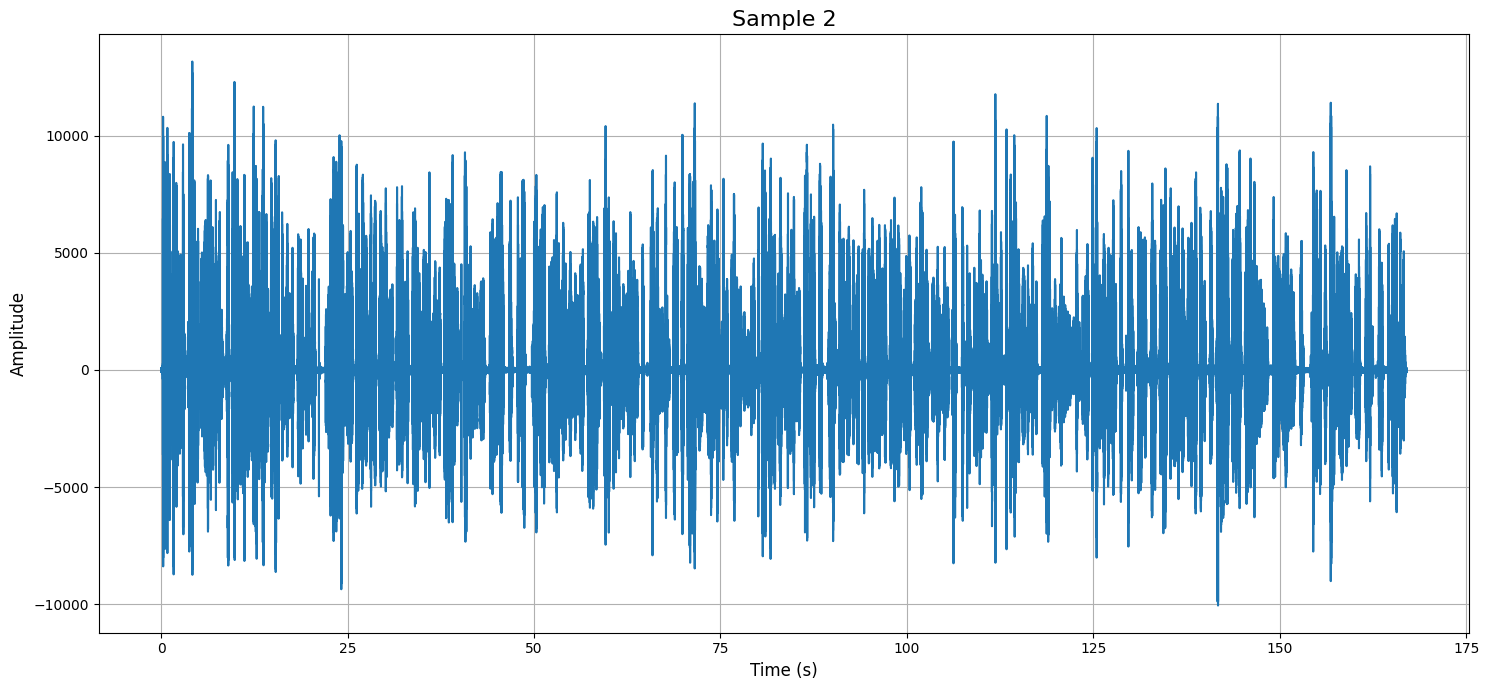

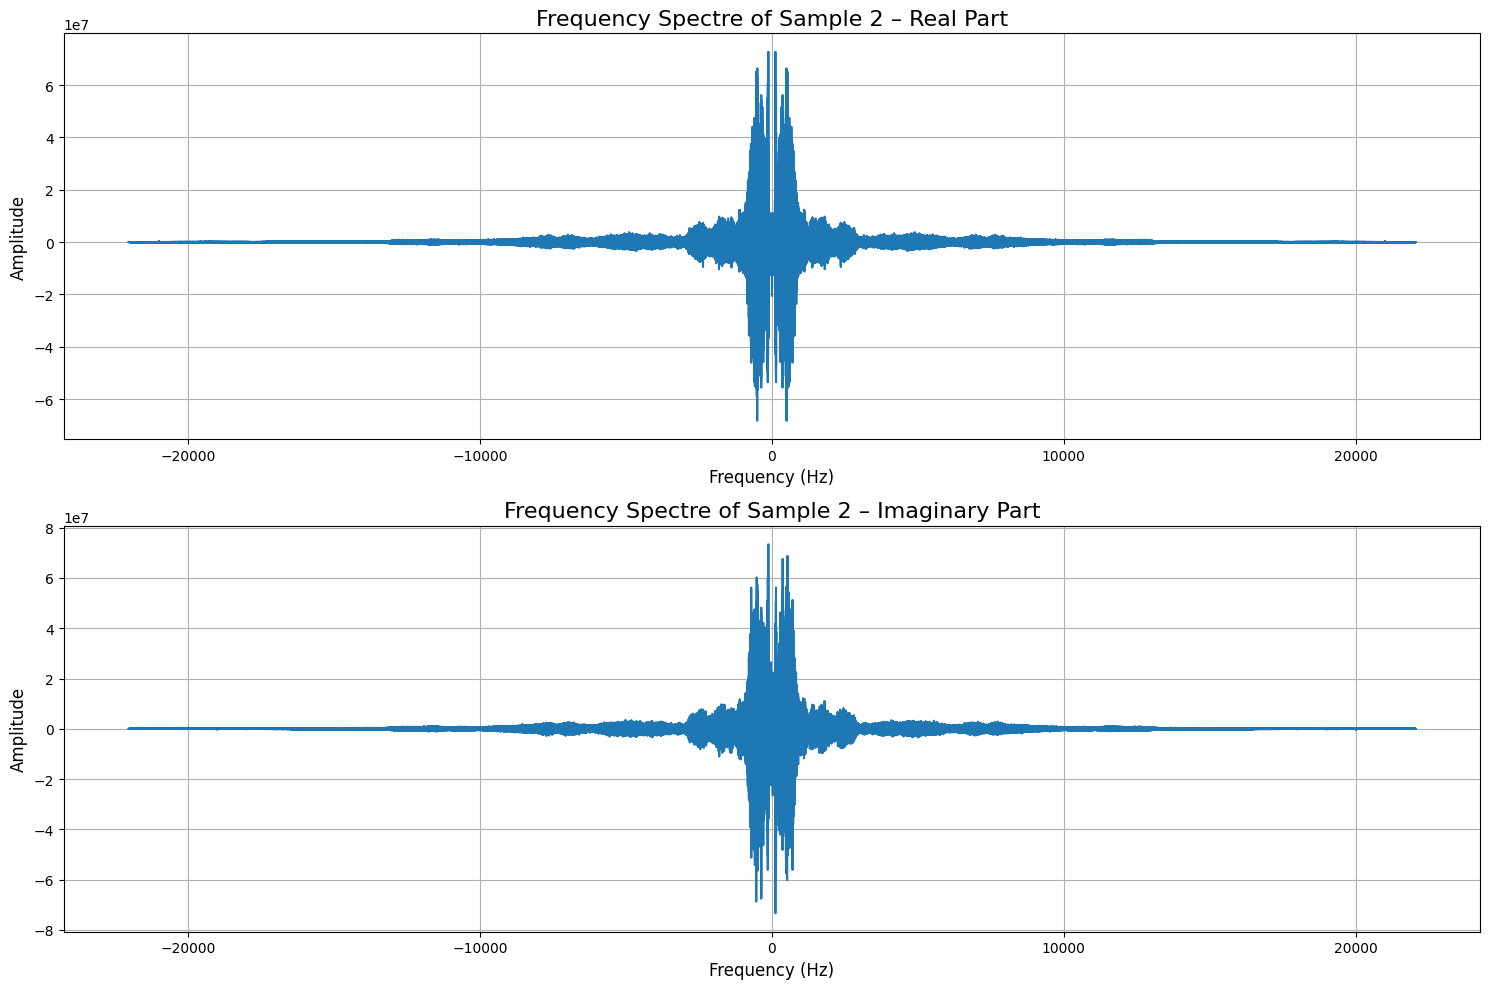

In [70]:
samplerate, signal2 = wavfile.read("sample2.wav")
print("Samplerate: ", samplerate)
data = signal2[:, 0]  # Getting the first channel from wav file
plot_signal(data, "Sample 2")
plot_dft(data, "Frequency Spectre of Sample 2")

## 2. Perform amplitude modulation of both the samples 


In [71]:
# Truncate longer signal
min_len = min(len(signal1), len(signal2))
signal1 = signal1[:min_len]
signal2 = signal2[:min_len]

data1 = signal1[:, 0]
fc1 = 8000
t = np.arange(len(data1)) / samplerate
carrier1 = np.cos(2 * np.pi * fc1 * t)
mod1 = carrier1 * data1

data2 = signal2[:, 0]
fc2 = 16000
t = np.arange(len(data1)) / samplerate
carrier2 = np.cos(2 * np.pi * fc2 * t)
mod2 = carrier2 * data2

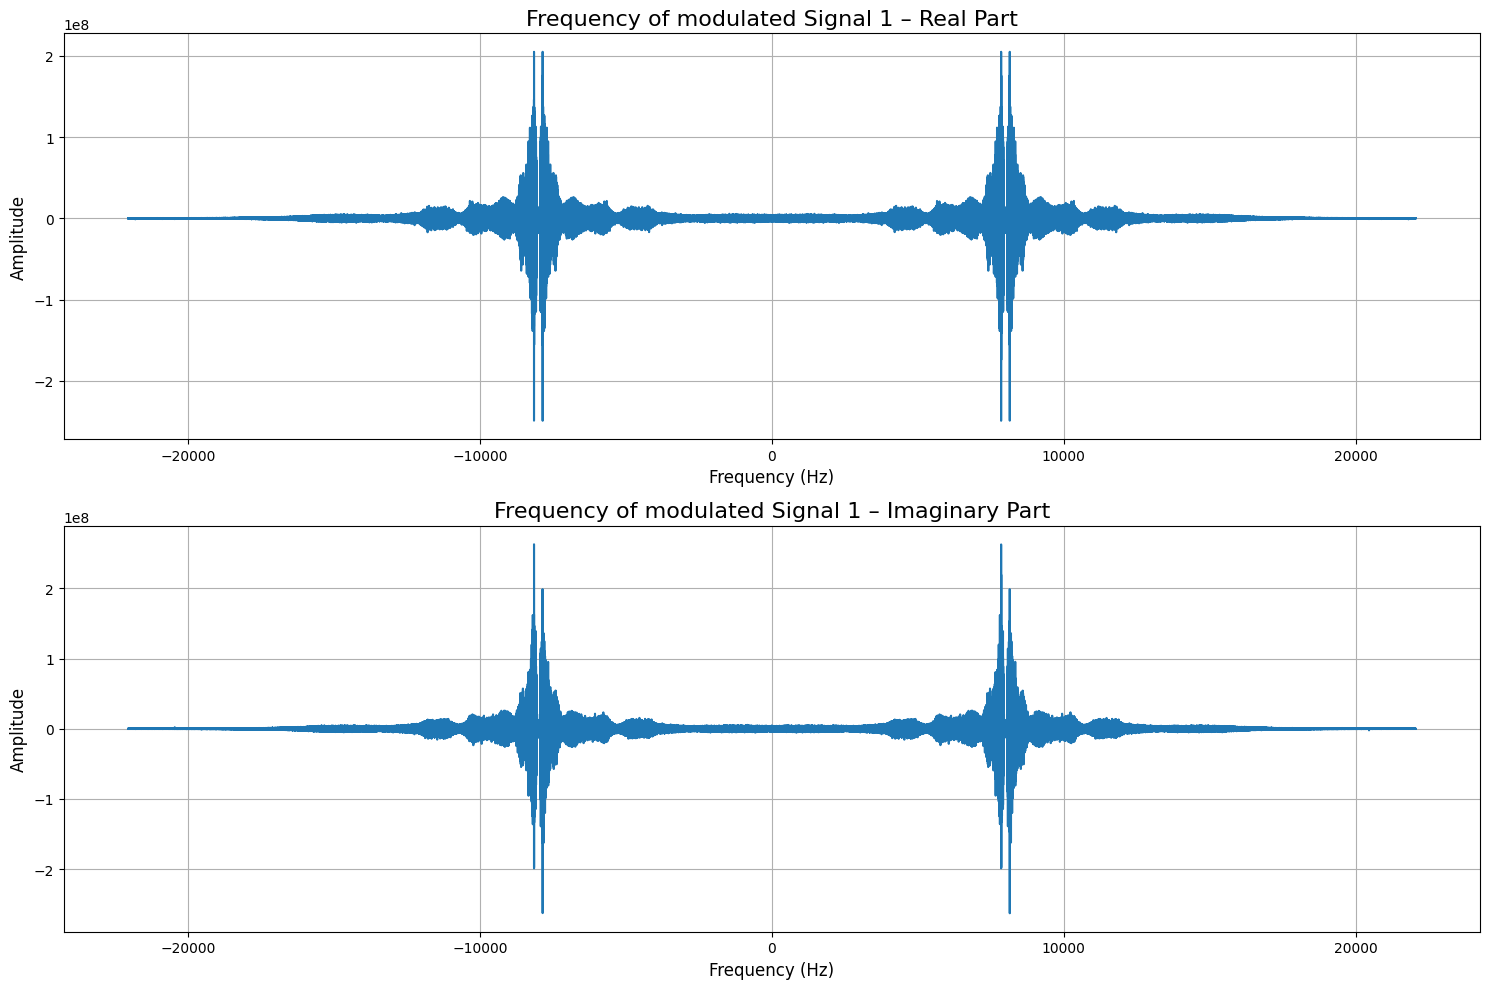

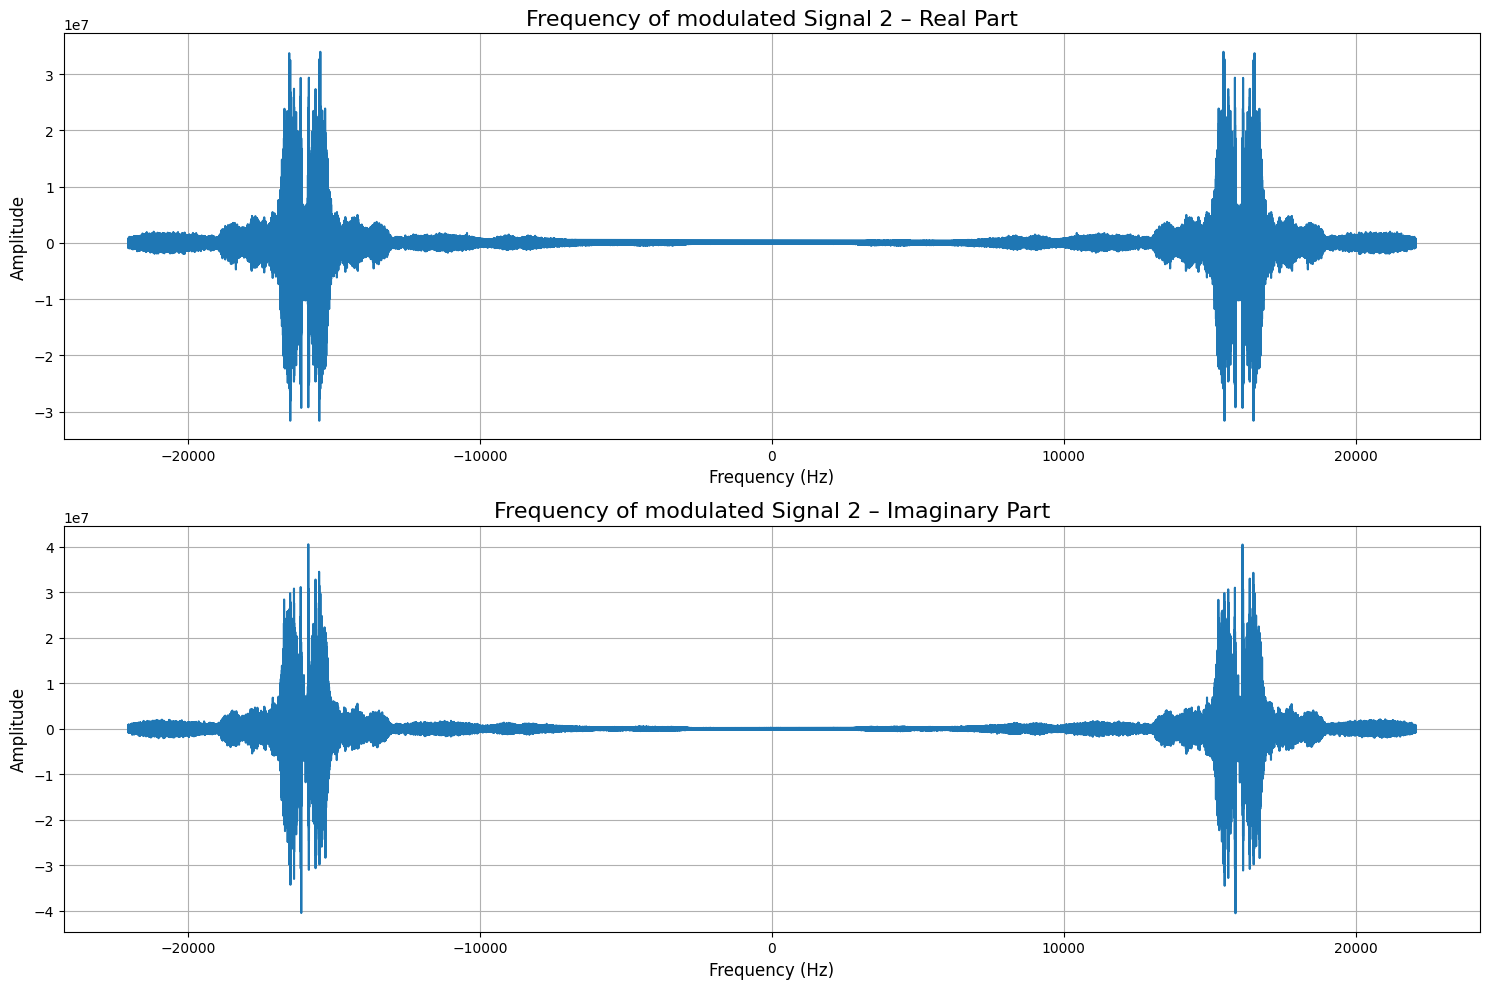

In [72]:
plot_dft(mod1, "Frequency of modulated Signal 1")
plot_dft(mod2, "Frequency of modulated Signal 2")

## 3. Combine the signals

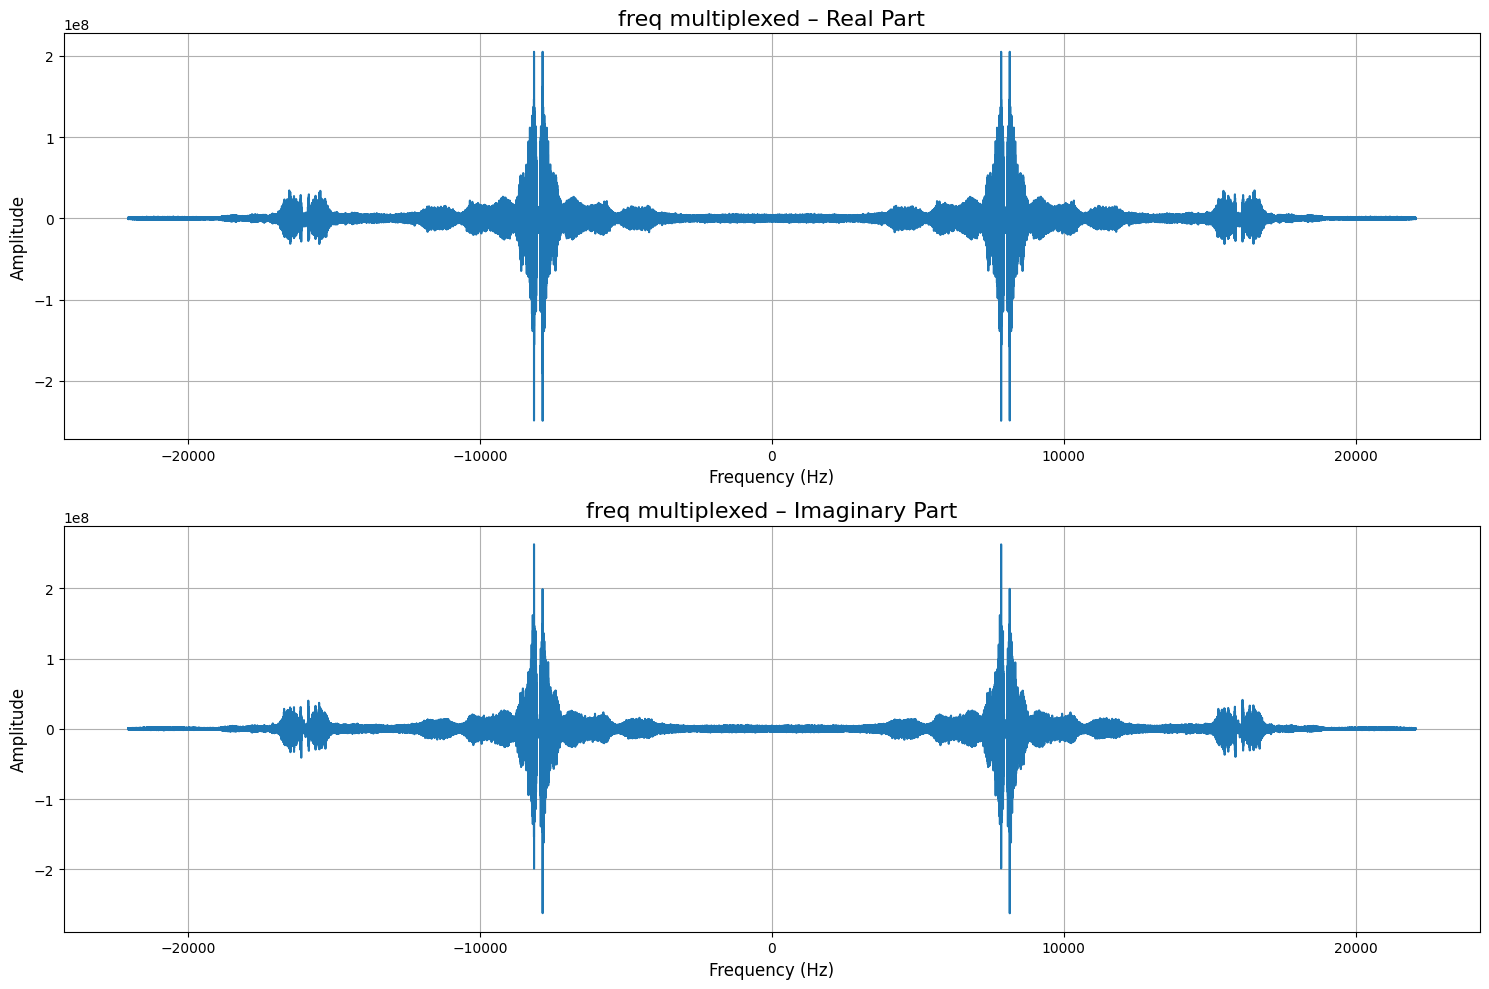

In [73]:
multiplexed = mod1 + mod2
plot_dft(multiplexed, "freq multiplexed")

## 4. Filter

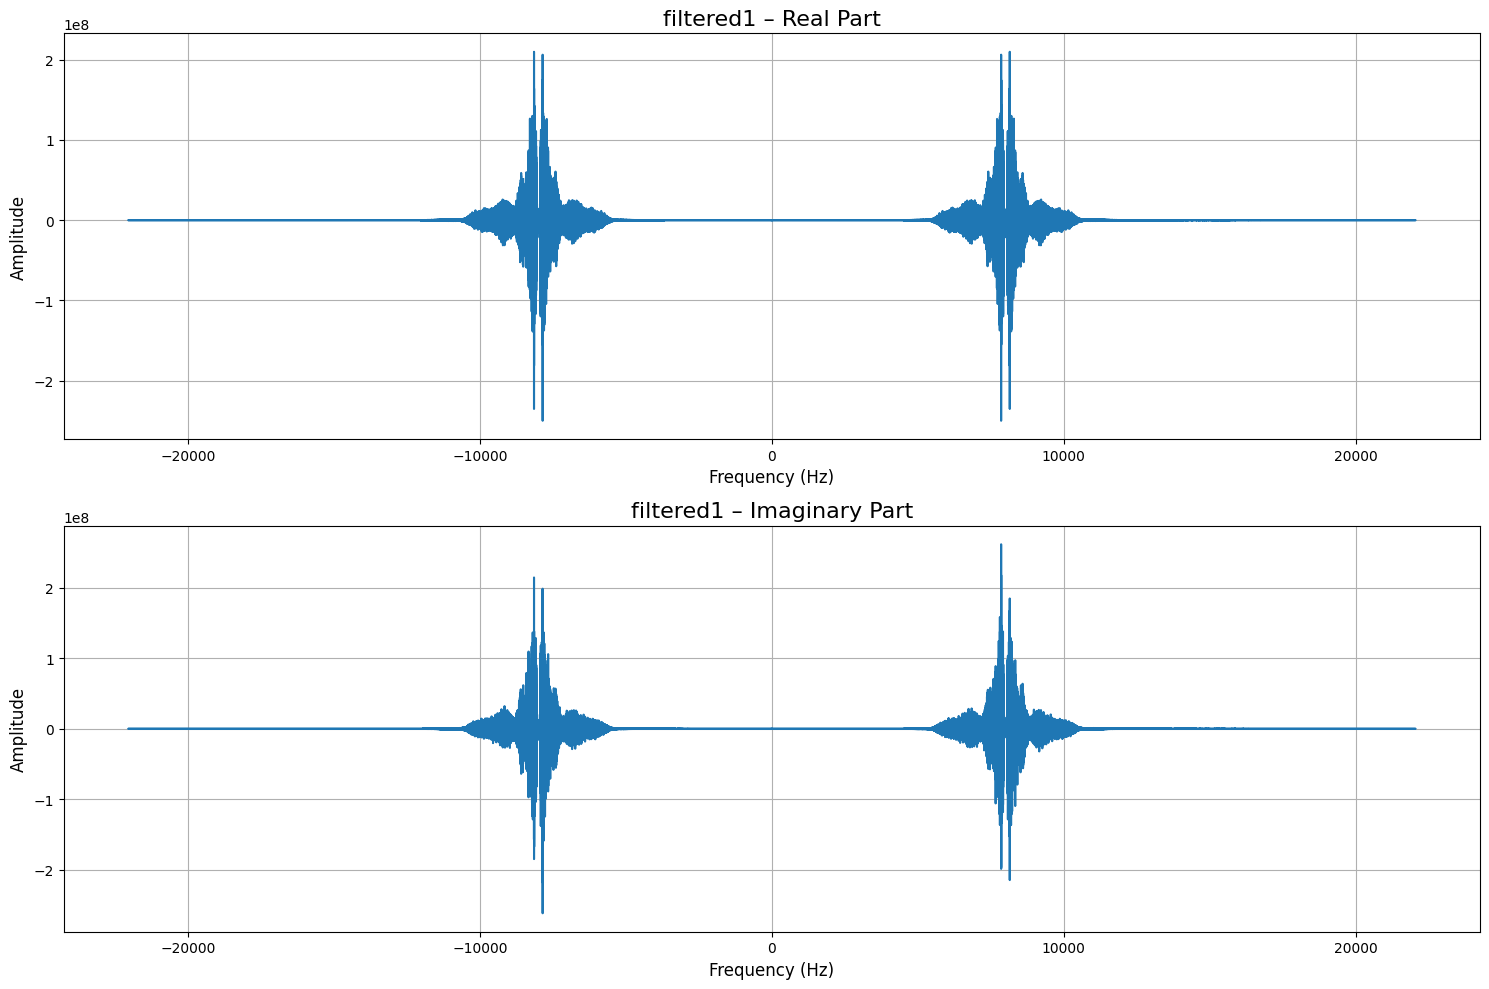

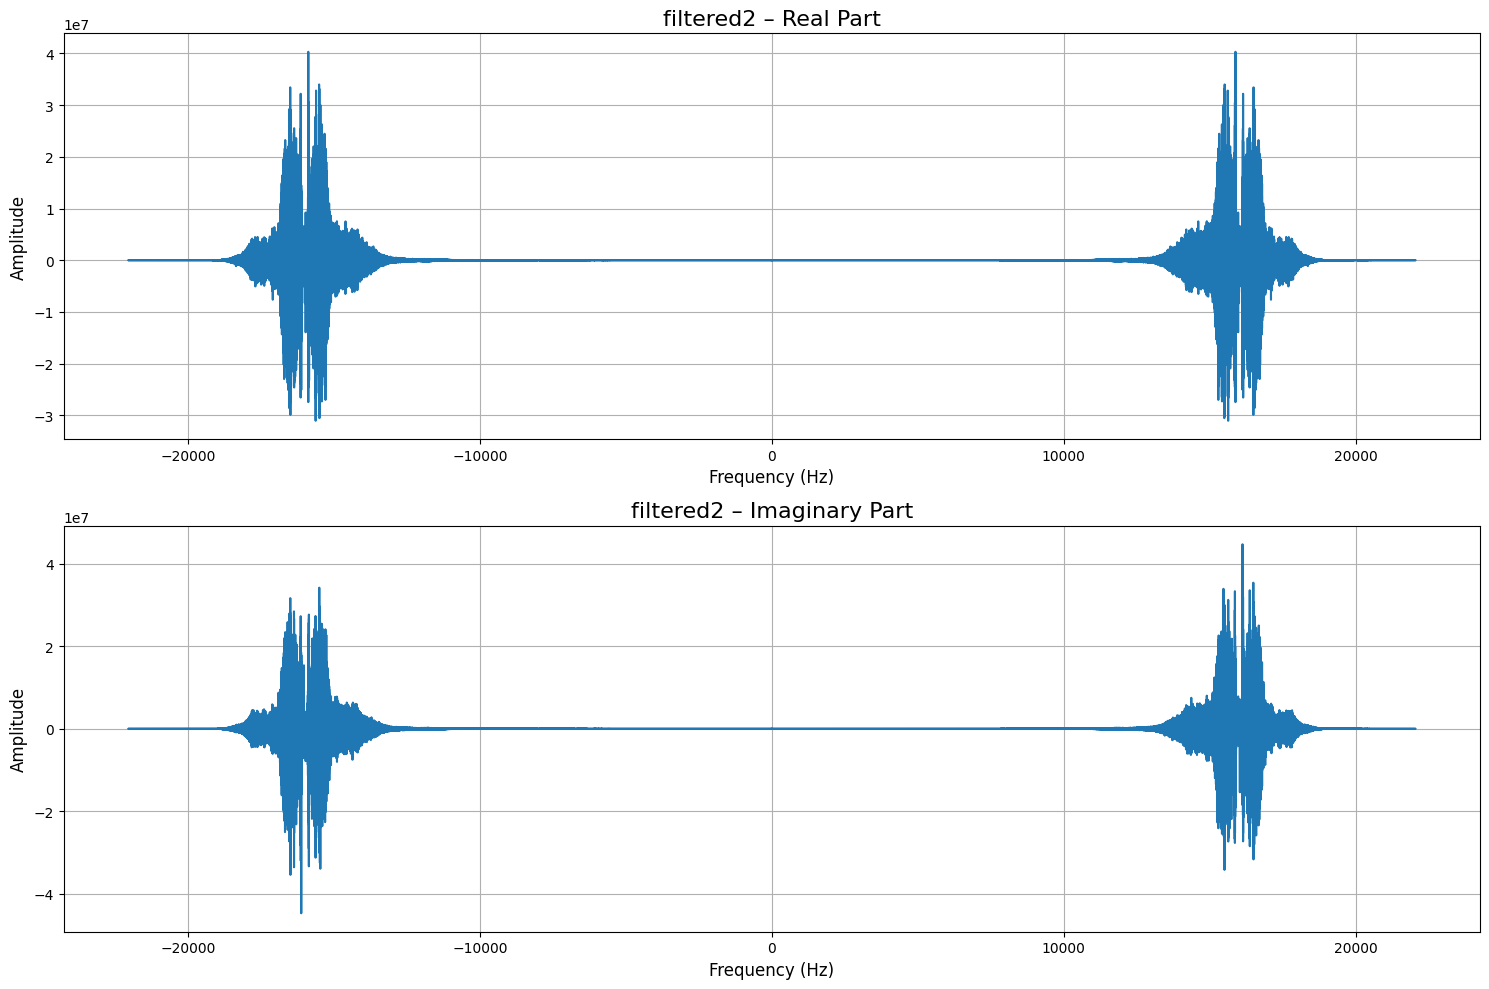

In [74]:
def bandpass_filter(signal, lowcut, highcut, fs, order=6):
    sos = butter(order, [lowcut, highcut], btype='bandpass', fs=fs, output='sos')
    return sosfilt(sos, signal)


filtered1 = bandpass_filter(multiplexed, fc1 - 2000, fc1 + 2000, samplerate)
filtered2 = bandpass_filter(multiplexed, fc2 - 2000, fc2 + 2000, samplerate)

plot_dft(filtered1, "filtered1")
plot_dft(filtered2, "filtered2")

## 5. Perform demodulation

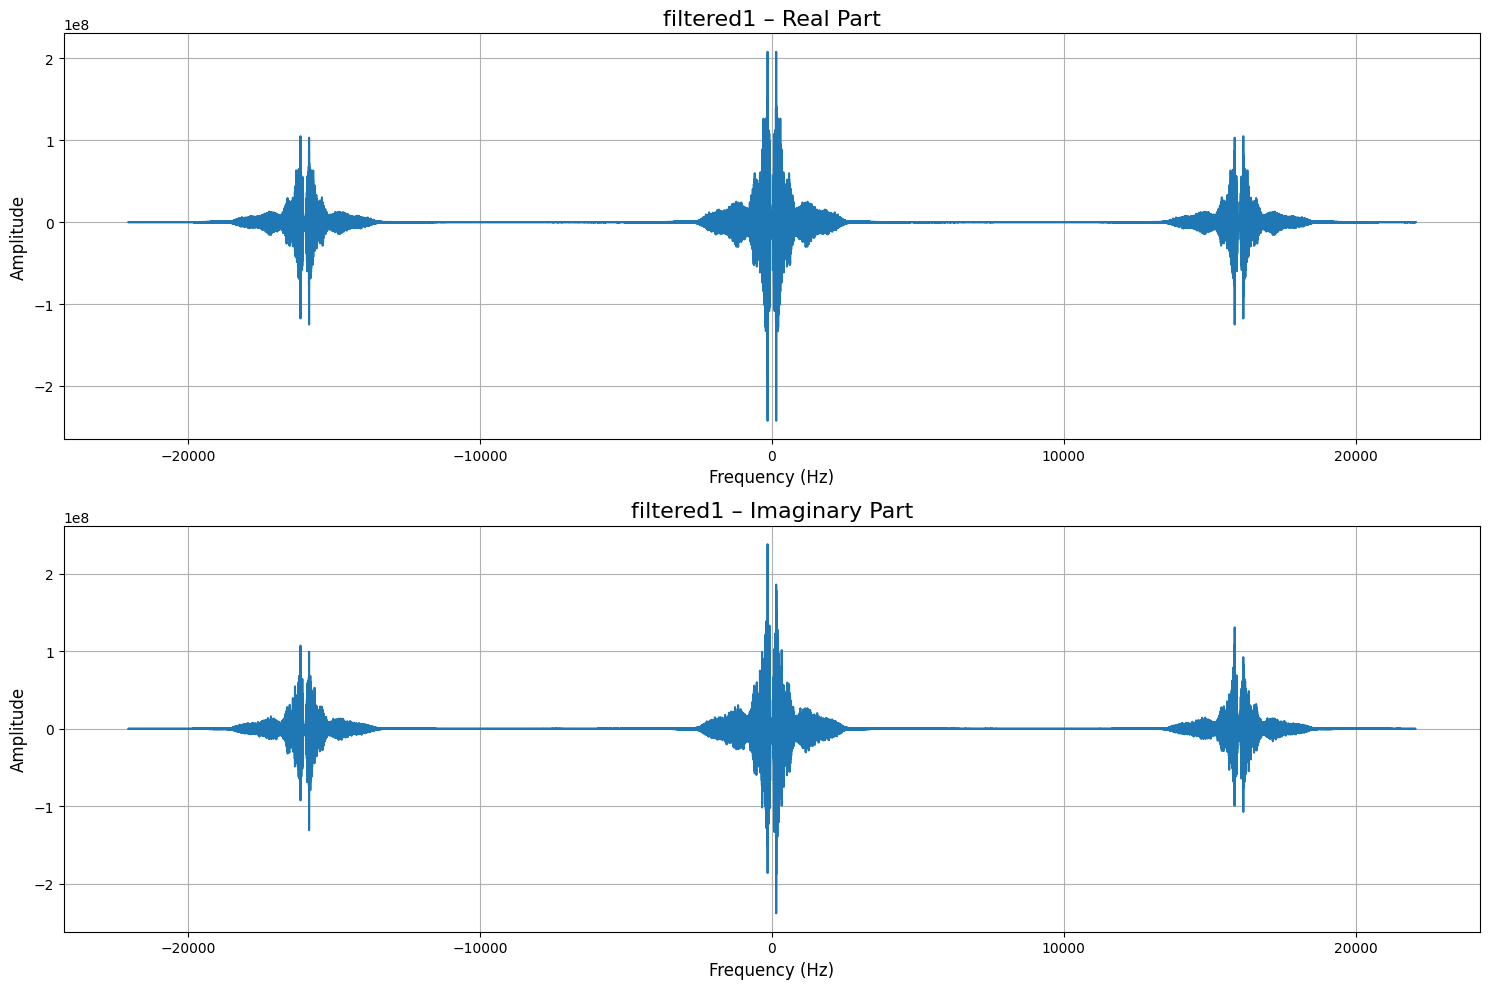

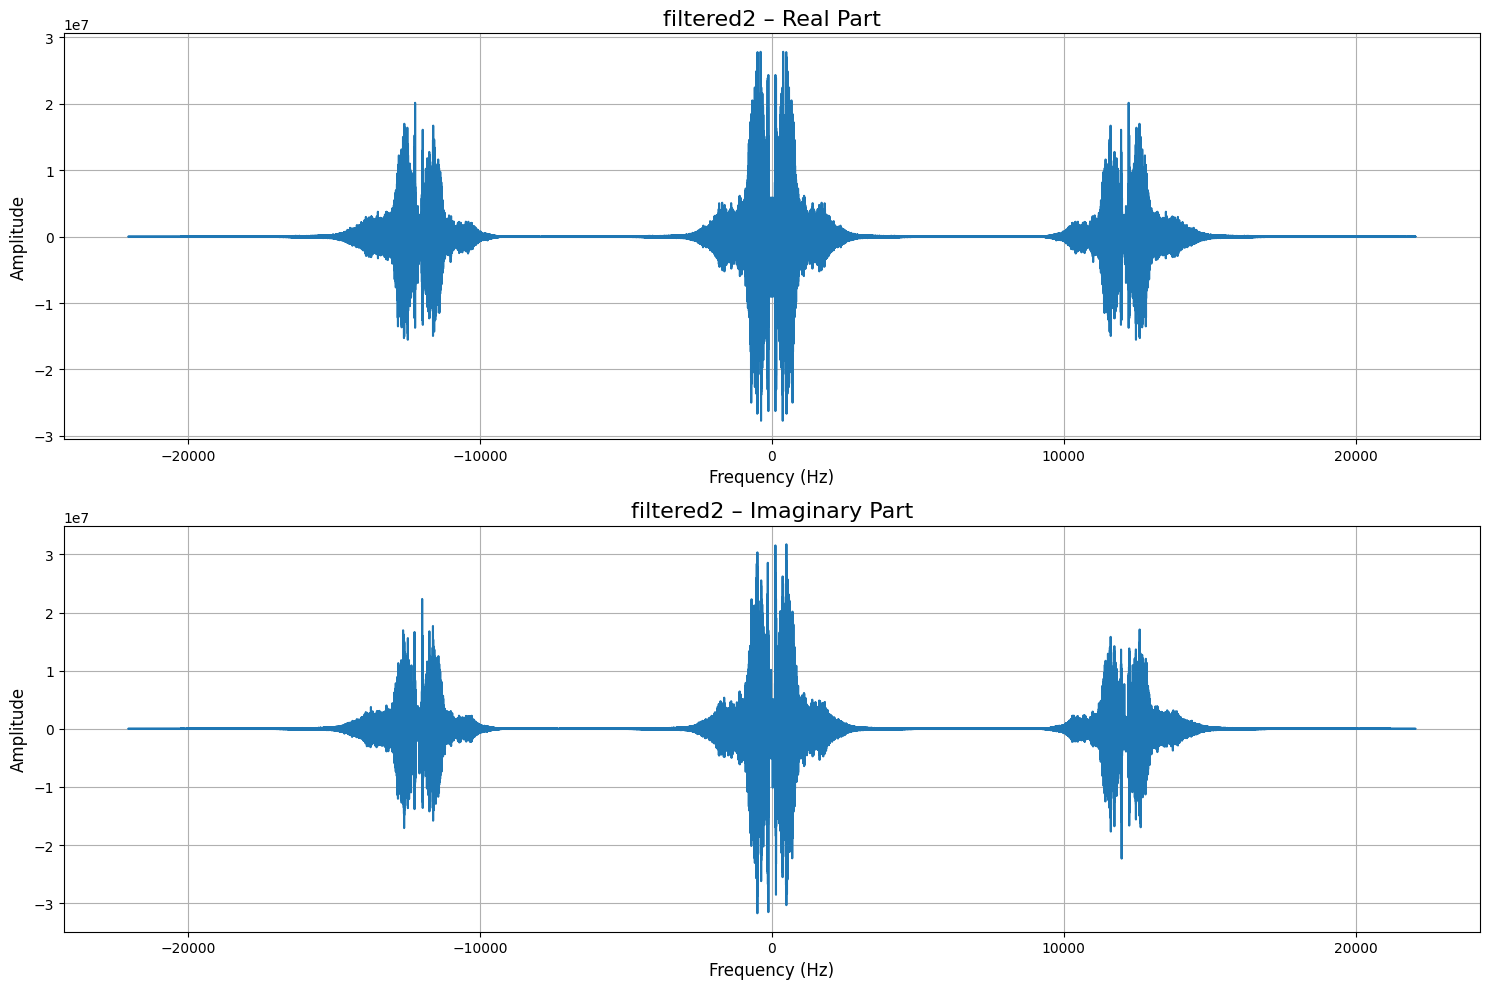

In [75]:
demod1 = filtered1 * carrier1
demod2 = filtered2 * carrier2

plot_dft(demod1, "filtered1")
plot_dft(demod2, "filtered2")

## 6. Lowpass filtering for removing noise

In [76]:
def lowpass_filter(signal, cutoff, fs, order=6):
    sos = butter(order, cutoff, btype='lowpass', fs=fs, output='sos')
    return sosfilt(sos, signal)


recovered1 = lowpass_filter(demod1, 4000, samplerate)
recovered2 = lowpass_filter(demod2, 4000, samplerate)

recovered1 /= np.max(np.abs(recovered1))
recovered2 /= np.max(np.abs(recovered2))

## 7. Compare original from demodulated signal

In [77]:
write("recovered1.wav", samplerate, (recovered1 * 32767).astype(np.int16))
write("recovered2.wav", samplerate, (recovered2 * 32767).astype(np.int16))